In [2]:
import sys
sys.path.append('/mnt/disk05/note/workspaces/duxx')
from feature_selector import FeatureSelector
from unity import init_pkg as ini
import os
import json
import datetime
import gc
# import pandas_profiling

% matplotlib inline

In [4]:
df_list = []
for f in os.listdir('data/bd'):
    if ('xlsx' in f) and (('7' in f) or ('8' in f)):
        print(f)
        each = ini.pd.read_excel('data/bd/'+f)
        df_list.append(each)
bdbank = ini.pd.concat(df_list).reset_index(drop=True)
# bdbank = ini.pd.read_pickle('data/bd/bdbank.pkl')
bdbank = bdbank.reset_index(drop=True)

百度7月份进件.xlsx
百度8月份进件.xlsx


In [5]:
bdbank = bdbank[bdbank['CREATED_DATE'].dt.month.isin([3,4,5,6,7,8])]
bdbank.head()

,ID,CUST_NAME,ID_CARD_NO,MOBILE_NO,BANK_CARD_NO,CREATED_DATE,UPDATED_DATE,EXPANDING,TRANSACTION_TYPE,TRANSACTION_ID,ORDER_NO,INIT_AMOUNT,ANNUAL_INT_RATE,CASH_AMOUNT,AFTER_LMT,BEFORE_LMT,PRE_A_CUST_SEG
0,99c296b172d776050173062b375340c6,邬敏,340303199104300628,15256088646,6225885550298723,2020-07-01 00:59:22,2020-07-01 00:59:22,"{""zxCreditCardDelqStatus30To60Days"":""N"",""zxHou...",transaction,1443285724749185921,2202007014461363434401283652_44613634344012836...,300000.0,1.80,3000.0,NaN,NaN,NaN
1,99c296b272d77d0b0173066b7ac83999,柴伟昭,130435199511202117,13403205444,6222030405007072035,2020-07-01 02:09:33,2020-07-01 02:09:33,"{""zxCreditCardDelqStatus30To60Days"":""N"",""zxHou...",transaction,4404941376746008373,2202007014461371543299543869_44613715432995438...,1600000.0,1.80,3000.0,NaN,NaN,NaN
2,99c296b172d77605017306bf50774978,叶挺,362321199110083015,18607936769,6214835721919833,2020-07-01 03:41:07,2020-07-01 03:41:07,"{""zxCreditCardDelqStatus30To60Days"":""N"",""zxHou...",transaction,1194959719284130132,2202007014458412310832539904_44584123108325399...,3150000.0,1.62,4000.0,NaN,NaN,NaN
3,99c296b172d77605017306c5c1b1499f,刘兴,51162319870815393X,15086883670,6214830234906617,2020-07-01 03:48:10,2020-07-01 03:48:10,"{""zxCreditCardDelqStatus30To60Days"":""N"",""zxHou...",apply,1104147582824328505,2202007014455599897527617134_44555998975276171...,50000.0,0.00,NaN,NaN,NaN,NaN
4,99c296b272d77d0b017306d7a49e141b,陈智铭,440804199011040510,13668991209,6225881208407428,2020-07-01 04:07:42,2020-07-01 04:07:42,"{""zxCreditCardDelqStatus30To60Days"":""N"",""zxHou...",transaction,1170333519472257787,2202007014458420179212638736_44584201792126387...,12000000.0,1.44,10000.0,NaN,NaN,NaN


In [6]:
bdfea = ini.pd.io.json.json_normalize(bdbank['EXPANDING'].fillna('{}').apply(json.loads))

In [7]:
bdbank = bdbank.drop('EXPANDING',axis=1)
bdbank = ini.pd.concat([bdbank,bdfea],axis=1)
del bdfea

In [8]:
bdbank.to_pickle('data/bd/ext_bdbank.pkl')
# break

In [32]:
summary_df = ini.pd.DataFrame(bdbank.dtypes,columns=['type'])
summary_df.head()

,type
ID,object
CUST_NAME,object
ID_CARD_NO,object
MOBILE_NO,int64
BANK_CARD_NO,object


In [33]:
drop_feas = set()

# 1.数据质量检查

## 1.1 主键唯一性检查
主键没有重复情况

In [34]:
len(bdbank['ID'].unique())

168028

In [35]:
bdbank.shape

(168028, 140)

## 1.2 历史数据观测
数据都是2020年8，9，10，11，12月的进件数据

In [36]:
bdbank['CREATED_DATE'].dt.month.unique()

array([3, 4, 5, 6])

## 1.3 缺失值检查

In [37]:
fs = FeatureSelector(data=bdbank,labels=bdbank['ID'])

In [38]:
fs.identify_missing(0.5)
fs.ops['missing']

21 features with greater than 0.50 missing values.



['CASH_AMOUNT',
 'AFTER_LMT',
 'BEFORE_LMT',
 'PRE_A_CUST_SEG',
 'cashAmount',
 'compreAnnualInterestRate',
 'dailyInterestRate',
 'dailyPenaltyRate',
 'idpicture0',
 'idpicture1',
 'ifIdPicture',
 'ifLiving',
 'livingPhoto',
 'ocrExpdate',
 'ocrNation',
 'ocrSignOrg',
 'orderId',
 'photowithidcard',
 'term',
 'unionLoanUsed',
 'usedTotalLimit']

In [39]:
drop_feas = drop_feas | set(fs.ops['missing'])

## 1.4 单一值检查

In [40]:
fs.identify_single_unique()
fs.ops['single_unique']

6 features with a single unique value.



['bidNormalScoreExp3',
 'creditValidityDays',
 'phoneNormalScoreExp3',
 'prcidNormalScoreExp3',
 'risCode',
 'zxCreCardStatus2']

In [41]:
drop_feas = drop_feas | set(fs.ops['single_unique'])

In [42]:
summary_df['缺失大于50%'] = '否'
summary_df.loc[fs.ops['missing'],'缺失大于50%'] = '是'
summary_df['是否单一值'] = '否'
summary_df.loc[fs.ops['single_unique'],'是否单一值'] = '是'
summary_df['COUNT'] = bdbank.count()

In [43]:
summary_df.to_excel('summary.xlsx')

# 2.数据探索

## 2.1 申请数量

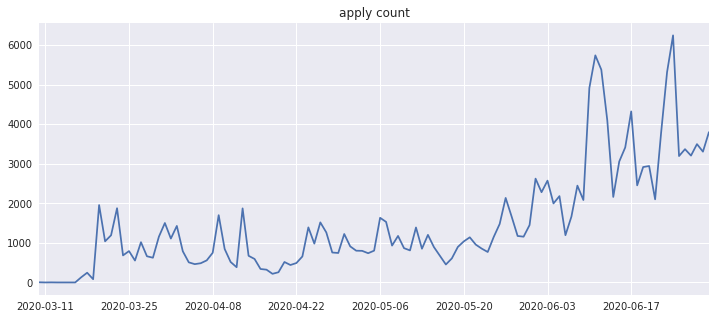

In [18]:
bdbank['CREATED_DATE'].dt.date.value_counts().sort_index().plot(title='apply count',figsize=(12,5))

In [19]:
bdbank['上下旬'] = '上旬'
bdbank.loc[bdbank['CREATED_DATE'].dt.day > 15,'上下旬'] = '下旬'
bdbank['月份'] = bdbank['CREATED_DATE'].dt.month
bdbank.groupby(['月份','上下旬'])['ID'].count().unstack()

上下旬,上旬,下旬
月份,,
3,11,13537
4,12697,11145
5,15364,16949
6,44426,53899


In [20]:
bdbank['CREATED_DATE'].dt.date.value_counts().sort_index().to_excel('授信申请数.xlsx')

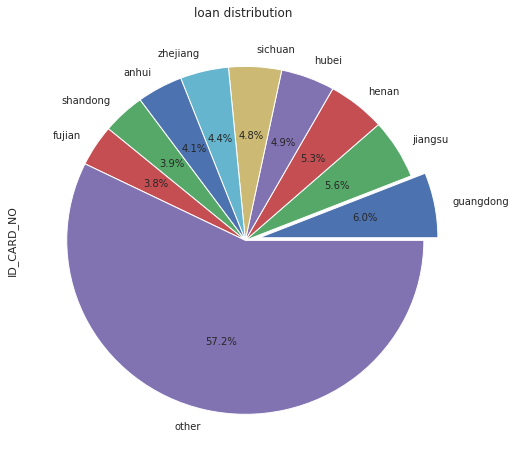

In [396]:
# 申请数量地区分布
prov_names = {'340':'anhui','320':'jiangsu','370':'shandong','420':'hubei','450':'guangxi','430':'hunan','410':'henan',
              '510':'sichuan','440':'guangdong','350':'fujian','330':'zhejiang'}
prov_count = (bdbank['ID_CARD_NO'].str.slice(0,2).astype(int) * 10).astype(str).value_counts()
prov_count.rename(prov_names,inplace=True)
split_index = prov_count.head(10).index[-1]
prov_count.loc[split_index] = prov_count.loc[split_index:].sum()
prov_count.loc[split_index] = prov_count.loc[split_index:].sum()
prov_count.rename({split_index:'other'},inplace=True)
prov_count = prov_count[:'other']
explodes = [0]*10
explodes[0] = 0.08
prov_count.plot.pie(figsize=(8,8),labeldistance=1.1,explode=explodes,autopct='%.1f%%',
                    wedgeprops={'linewidth':1, 'edgecolor':'white'},
                   title='loan distribution ')

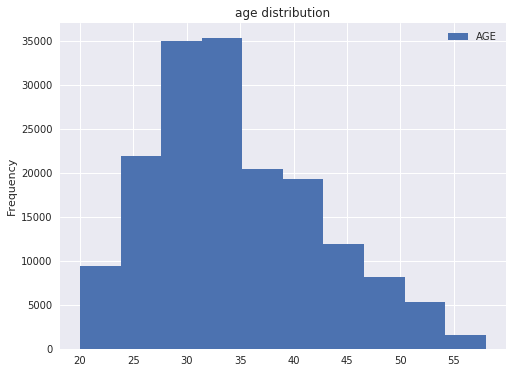

In [54]:
# 申请数量年龄分布
(2020-bdbank['ID_CARD_NO'].str.slice(6,10).astype(int)).plot.hist(figsize=(8,6),title='age distribution',label='AGE',legend=True)

## 2.2 授信利率分布

Text(0.5,1,'annual int rate distribution')

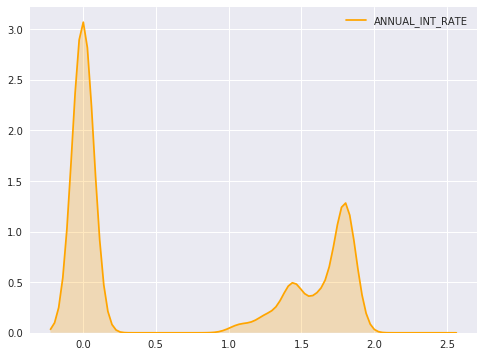

In [70]:
ini.plt.figure(figsize=(8,6))
ini.sns.kdeplot(bdbank['ANNUAL_INT_RATE'].fillna(0),shade=True,color='orange')
ax.set_title('annual int rate distribution')

## 2.3 授信金额分布

Text(0.5,1,'init amount distribution')

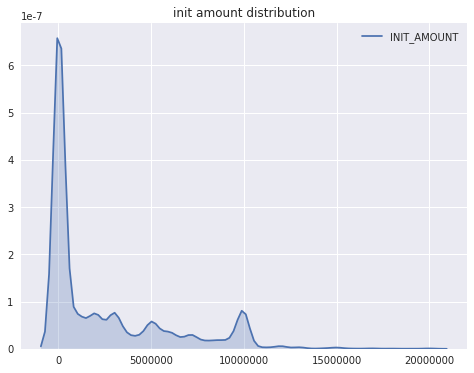

In [68]:
ini.plt.figure(figsize=(8,6))
ini.sns.kdeplot(bdbank['INIT_AMOUNT'].fillna(0),shade=True)
# 取消科学计数法
ax = ini.plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set_title('init amount distribution')

## 2.4 逾期滚动率

In [290]:
# 贷后数据
ov_list = []
for f in range(3,13):
    data = ini.pd.read_csv(f'data/bd/slice/bd_dubil_{f}.csv')
    if f > 11:
        f = 0
        date = f'2021-{f+1}'
    else:
        date = f'2020-{f+1}'
    part_ym = (datetime.datetime.strptime(date,'%Y-%m')-datetime.timedelta(seconds=3)).date()
    data['part_ym'] = part_ym
    ov_list.append(data)
bdovdue = ini.pd.concat(ov_list)
bdovdue = bdovdue.reset_index(drop=True)

In [387]:
def mob_trans(mob_pivot):
    pivot_df = mob_pivot.copy()
    pivot_df['M8+'] = pivot_df.iloc[:,8:].sum(axis=1)
    pivot_df = pivot_df[['M0','M1','M2','M3','M4','M5','M6','M7','M8+']]
    pivot_df.loc['M7+'] = pivot_df['M7':].sum()
    pivot_df = pivot_df[:'M6'].append(pivot_df.loc['M7+'])
    pivot_df['总计'] = pivot_df.sum(axis=1)
    pivot_df.loc['总计'] = pivot_df.sum()
    return pivot_df

In [291]:
bdovdue.head()

,dubil_no,ovdue_days,lon_dt,cert_no,part_ym
0,4149488817617242325,0,2020-03-21,430281198410177868,2020-03-31
1,4170320439806389279,0,2020-03-26,12022219960310582X,2020-03-31
2,4149381924471107758,0,2020-03-24,210111198412071527,2020-03-31
3,4170354524666868346,0,2020-03-26,510104198211082876,2020-03-31
4,4176538246784740863,0,2020-03-29,410402198602125677,2020-03-31


In [292]:
bdovdue['lon_mon'] = bdovdue['lon_dt'].astype(str).str.slice(0,7)
bdovdue['lon_dt'] = bdovdue['lon_dt'].astype('datetime64[ns]')

In [301]:
bse_mons = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in ['2020-11-30','2020-12-31']]
roll_df = bdovdue[bdovdue['part_ym'].isin(bse_mons)]
roll_df['ov1'],roll_df['ov2'] = 0,0
roll_df.loc[roll_df['part_ym']==bse_mons[0],'ov1'] = roll_df['ovdue_days']
roll_df.loc[roll_df['part_ym']==bse_mons[1],'ov2'] = roll_df['ovdue_days']
roll_df = roll_df.groupby('dubil_no')[['ov1','ov2']].max()
roll_df['d1'] = roll_df['ov1'].apply(lambda x:'M0' if x == 0 else 'M' + str(((x-1)//30)+1))
roll_df['d2'] = roll_df['ov2'].apply(lambda x:'M0' if x == 0 else 'M' + str(((x-1)//30)+1))

In [388]:
mob = roll_df.reset_index().groupby(['d1','d2'])['dubil_no'].count().reset_index()
mob_pivot = mob.pivot_table(index='d1',columns='d2',values='dubil_no')
mob_pivot

d2,M0,M1,M2,M3,M4,M5,M6,M7,M8,M9
d1,,,,,,,,,,
M0,864137.0,1637.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M1,289.0,226.0,842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M2,36.0,10.0,23.0,579.0,14.0,NaN,NaN,NaN,NaN,NaN
M3,3.0,NaN,NaN,1.0,422.0,8.0,NaN,NaN,NaN,NaN
M4,4.0,NaN,2.0,1.0,2.0,178.0,6.0,NaN,NaN,NaN
M5,6.0,NaN,NaN,NaN,1.0,2.0,101.0,NaN,NaN,NaN
M6,NaN,NaN,NaN,NaN,NaN,NaN,1.0,27.0,NaN,NaN
M7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN
M8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [389]:
mob_pivot = mob_trans(mob_pivot)
mob_pivot

d2,M0,M1,M2,M3,M4,M5,M6,M7,M8+,总计
d1,,,,,,,,,,
M0,864137.0,1637.0,70.0,NaN,NaN,NaN,NaN,NaN,0.0,865844.0
M1,289.0,226.0,842.0,NaN,NaN,NaN,NaN,NaN,0.0,1357.0
M2,36.0,10.0,23.0,579.0,14.0,NaN,NaN,NaN,0.0,662.0
M3,3.0,NaN,NaN,1.0,422.0,8.0,NaN,NaN,0.0,434.0
M4,4.0,NaN,2.0,1.0,2.0,178.0,6.0,NaN,0.0,193.0
M5,6.0,NaN,NaN,NaN,1.0,2.0,101.0,NaN,0.0,110.0
M6,NaN,NaN,NaN,NaN,NaN,NaN,1.0,27.0,0.0,28.0
M7+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0
总计,864475.0,1873.0,937.0,581.0,439.0,188.0,108.0,27.0,13.0,868641.0


In [390]:
mob_pivot.to_excel('roll_ratio.xlsx')

In [305]:
roll_df[(roll_df['d1'] == 'M5') & (roll_df['d2'] == 'M0')]

,ov1,ov2,d1,d2
dubil_no,,,,
4256577161416474103,126,0,M5,M0
4256633683186132965,144,0,M5,M0
4333368737171298158,149,0,M5,M0
4333401963038329558,126,0,M5,M0
4425466545585799198,126,0,M5,M0
4437812171387237678,126,0,M5,M0


In [306]:
bdovdue[bdovdue['dubil_no'] == 4256577161416474103]

,dubil_no,ovdue_days,lon_dt,cert_no,part_ym,lon_mon
10039,4256577161416474103,0,2020-04-29,522425198105036405,2020-04-30,2020-04
30952,4256577161416474103,0,2020-04-29,522425198105036405,2020-05-31,2020-04
81739,4256577161416474103,0,2020-04-29,522425198105036405,2020-06-30,2020-04
194961,4256577161416474103,4,2020-04-29,522425198105036405,2020-07-31,2020-04
385268,4256577161416474103,34,2020-04-29,522425198105036405,2020-08-31,2020-04
667584,4256577161416474103,65,2020-04-29,522425198105036405,2020-09-30,2020-04
1104542,4256577161416474103,96,2020-04-29,522425198105036405,2020-10-31,2020-04
1732018,4256577161416474103,126,2020-04-29,522425198105036405,2020-11-30,2020-04
2530462,4256577161416474103,0,2020-04-29,522425198105036405,2020-12-31,2020-04


## 2.5 账龄分析

In [308]:
gc.collect()
del bdbank

In [331]:
bdovdue['time_diff'] = ((bdovdue['part_ym'] - bdovdue['lon_dt'].dt.date).dt.days // 30)
bdovdue['vintage'] = 'MOB' + bdovdue['time_diff'].astype(str)
bdovdue['m1'],bdovdue['m2'] = 0,0
bdovdue.loc[bdovdue['ovdue_days'] > 0,'m1'] = 1
bdovdue.loc[bdovdue['ovdue_days'] > 30,'m2'] = 1
vintage = bdovdue.pivot_table(index='lon_mon',columns='vintage',values='m2',aggfunc=lambda x:x.sum()/len(x))

In [358]:
vintage

vintage,MOB0,MOB1,MOB2,MOB3,MOB4,MOB5,MOB6,MOB7,MOB8,MOB9
lon_mon,,,,,,,,,,
2020-03,0.0,0.000000,0.000340,0.003061,0.003061,0.003061,0.004082,0.005782,0.006463,0.006122
2020-04,0.0,0.000000,0.000615,0.001388,0.003329,0.004511,0.006468,0.006152,0.007673,0.007919
2020-05,0.0,0.000000,0.001541,0.003983,0.005299,0.007491,0.009647,0.011660,0.010703,NaN
2020-06,0.0,0.000000,0.001464,0.003737,0.006606,0.009641,0.012195,0.011994,NaN,NaN
2020-07,0.0,0.000000,0.001014,0.003177,0.005198,0.006613,0.005944,NaN,NaN,NaN
2020-08,0.0,0.000026,0.001375,0.003578,0.005816,0.005883,NaN,NaN,NaN,NaN
2020-09,0.0,0.000020,0.000905,0.002845,0.002016,NaN,NaN,NaN,NaN,NaN
2020-10,0.0,0.000005,0.001027,0.001384,NaN,NaN,NaN,NaN,NaN,NaN
2020-11,0.0,0.000022,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [362]:
vintage.to_excel('vintage.xlsx')

## 2.6 累计客户逾期率

In [601]:
cert_group = bdovdue.groupby('cert_no')[['part_ym']].first()
cert_count = cert_group.groupby('part_ym').size()
tag = bdovdue[bdovdue['ovdue_days']>0]
tag = tag.groupby('part_ym')['cert_no'].apply(lambda x:len(x.unique()))
ovdue_count = ini.pd.concat([cert_count,tag],axis=1)
ovdue_count = ovdue_count.fillna(0)
ovdue_count.columns = ['累计合同数','累计逾期合同数']
ovdue_count.iloc[:,0] = ovdue_count.iloc[:,0].cumsum()
ovdue_count['累计客户逾期率'] = ovdue_count['累计逾期合同数']/ovdue_count['累计合同数']

In [602]:
ovdue_count

,累计合同数,累计逾期合同数,累计客户逾期率
2020-03-31,2094,0.0,0.000000
2020-04-30,7084,1.0,0.000141
2020-05-31,14351,15.0,0.001045
2020-06-30,37744,40.0,0.001060
2020-07-31,68685,141.0,0.002053
2020-08-31,88201,309.0,0.003503
2020-09-30,126381,591.0,0.004676
2020-10-31,197876,976.0,0.004932
2020-11-30,247323,1524.0,0.006162
2020-12-31,283600,2249.0,0.007930
